# Text Classification Bag of Words

Outline
- Download and explore the data
- Apply text processing techniques
- Implement bag of words model
- Train ML models for text classification
- Make predictions and publish to kaggle


## Download and explore the data

In [ ]:
!pip3 install kaggle

In [6]:
import os


In [7]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [8]:
!kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p data

403 - Forbidden - You must accept this competition's rules before you'll be able to download files.


In [16]:
train_fname = 'data/train.csv.zip'
test_fname = 'data/test.csv.zip'
sample_fname = 'data/sample_submission.csv.zip'

In [8]:
import pandas as pd


In [17]:
raw_df = pd.read_csv(train_fname)
raw_df
# insincere questions has target as 1 otherwise 0.

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [18]:
sincere_df = raw_df[raw_df['target'] == 0]
insincere_df = raw_df[raw_df['target'] == 1]
insincere_df['question_text'].values[:10]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

In [19]:
raw_df['target'].value_counts(normalize=True)

target
0    0.93813
1    0.06187
Name: proportion, dtype: float64

<Axes: xlabel='target'>

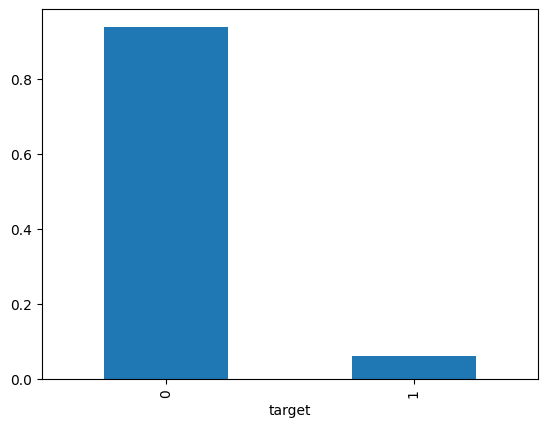

In [20]:
raw_df['target'].value_counts(normalize=True).plot(kind='bar')

In [22]:
test_df = pd.read_csv(test_fname)
test_df

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [23]:
sub_df = pd.read_csv(sample_fname)
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [26]:
SAMPLE_SIZE = 100_000

In [27]:
#Create working sample of data
sample_df = raw_df.sample(SAMPLE_SIZE, random_state=42)
sample_df

,qid,question_text,target
443046,56d324bb1e2c29f43b12,What is the most effective classroom managemen...,0
947549,b9ad893dc78c577f8a63,Can I study abroad after 10th class from Bangl...,0
523769,6689ebaeeb65b209a412,How can I make friends as a college junior?,0
949821,ba1e2c4a0fef09671516,How do I download free APK Minecraft: Pocket E...,0
1030397,c9ea2b69bf0d74626f46,"Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
998930,c3c03a307a29c69971b4,How do I research list of reliable charcoal im...,0
66641,0d119aba95ee6684f506,"What are petroleum products, and what is petro...",0
90024,11a46cd148a104b271cf,What are some services that will let you quick...,0
130113,1973e6e2111a0c93193a,What credit card processors do online marketpl...,0


## Apply text processing techniques

## Implement bag of words model

## Train ML models for text classification

## Make predictions and publish to kaggle